# 数据加载

In [2]:
import torchvision
import torch
from torch.utils import data
from torchvision import transforms

通过框架的内置函数将Fashion-MNIST数据集下载并读入到内存中

In [3]:
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root='./data', train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root='./data', train=False, transform=trans, download=True)

In [4]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [5]:
mnist_train[0][0].shape
# 第一个 0 -> 样本索引
# 第二个 0 -> 图像数据，第二个 0 的位置变为 1 则是 label

torch.Size([1, 28, 28])

In [6]:
mnist_train[0][1]

9

In [7]:
def get_fashion_mnist_labels(labels):
    """ 返回fashion-MNIST图像的文本标签 """
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

import matplotlib.pyplot as plt
import torch

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    # 创建子图
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    
    # 将axes数组展平，便于迭代
    axes = axes.flatten()
    
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量，转换为numpy数组
            ax.imshow(img.numpy())
        else:
            # PIL图片或其他数组格式
            ax.imshow(img)
        
        # 隐藏坐标轴
        ax.set_xticks([])
        ax.set_yticks([])
        
        # 设置标题（如果提供）
        if titles is not None:
            ax.set_title(titles[i])
    
    # 调整子图间距
    plt.tight_layout()
    return axes

几个样本的图像以及对应的标签

array([<Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'dress'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'pullover'}>,
       <Axes: title={'center': 'sneaker'}>,
       <Axes: title={'center': 'pullover'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sneaker'}>,
       <Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 'trouser'}>,
       <Axes: title={'center': 't-shirt'}>], dtype=object)

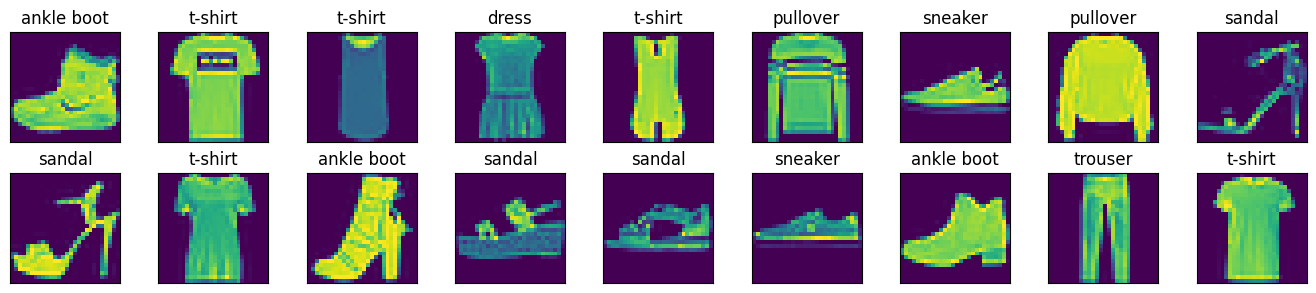

In [8]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y))

In [9]:
batch_size = 256

def get_dataloader_workers():
    return 4

train_iter = data.DataLoader(mnist_train, batch_size=batch_size, 
                             shuffle=True, num_workers=get_dataloader_workers())

import time

start_time = time.time()

for X, y in train_iter:
    continue

end_time = time.time()
delta = end_time - start_time
print(f'用时{delta : .2f} sec')

用时 0.44 sec


整合所有组件，用于获取和读取Fashion-MNIST数据集。
这个函数返回训练集和验证集的数据迭代器。
此外，这个函数还接受一个可选参数resize，用来将图像大小调整为另一种形状。

In [10]:
def load_data_fashion_mnist(batch_size, resize=None):
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)

    mnist_train = torchvision.datasets.FashionMNIST(root='./data', train=True, 
                                                   transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root='./data', train=False, 
                                                   transform=trans, download=True)

    return (data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, 
                          num_workers=get_dataloader_workers()), 
            data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, 
                          num_workers=get_dataloader_workers()))

指定resize参数来测试load_data_fashion_mnist函数的图像大小调整功能

In [11]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


# Softmax

In [12]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

原数据是1通道，28*28的图片，现在将其拉平成为784维向量。输出维度是10,因为有10类

In [13]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

实现Softmax(X)，X为矩阵

$$
Softmax(X)_{ij} = \frac{exp(X_{ij})}{\sum_{k}{exp(X_{ik})}}
$$

In [14]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(axis=1, keepdim=True)
    return X_exp / partition  # 这里应用了广播机制

X = torch.normal(0, 0.01, size=(2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.2016, 0.2024, 0.2002, 0.2003, 0.1956],
         [0.2012, 0.2024, 0.1997, 0.2000, 0.1967]]),
 tensor([1., 1.]))

### 实现Softmax模型

In [15]:
def net(X):
    return softmax(torch.matmul(X.reshape(-1, W.shape[0]), W) + b) # 注意要让 X 的列数等于 W 的行数

### 实现交叉熵损失函数
- 交叉熵损失只关心模型对正确类别的预测概率

In [16]:
# 高级索引
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

In [17]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[[range(len(y_hat))], y])

cross_entropy(y_hat, y)

tensor([[2.3026, 0.6931]])

In [18]:
def accuracy(y_hat, y):
    """ 计算预测正确的数量 """
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1: # 至少有两个维度，第二个维度数量大于1（也就是不止1列）
        y_hat = y_hat.argmax(axis=1) # 选出每行最大的元素的下标，作为新的y_hat

    cmp = y_hat.type(y.dtype) == y # == 对数据类型敏感，所以对y_hat类型转化为y的类型
    return float(cmp.type(y.dtype).sum())

accuracy(y_hat, y) / len(y)

0.5

同样，对于任意数据迭代器data_iter可访问的数据集， 可以评估在任意模型net的精度。

In [19]:
class Accumulator:
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def evaluate_accuracy(net, data_iter):
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval() # 切换到评估模式，确保结果一致性
    metric = Accumulator(2) # 2 个元素的累加器
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel()) # 不断累加预测正确的数量、总预测数量

    return metric[0] / metric[1]

简单测试，使用随机初始化参数的模型看看

In [20]:
evaluate_accuracy(net, test_iter)

0.0954

### 定义一个函数来训练一个迭代周期

In [21]:
def train_epoch_ch3(net, train_iter, loss, updater):
    """ 训练模型一个迭代周期 """
    if isinstance(net, torch.nn.Module):
        net.train() # 将模型设置为训练模式

    metric = Accumulator(3) # 训练损失总和、训练准确数总和、样本数
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y) # 先预测
        # 计算梯度并更新参数
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad() # 清除上一轮的旧梯度
            l.mean().backward() # 反向传播：计算当前梯度
            updater.step() # 参数更新：应用梯度更新权重
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])

        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())

    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

辅助函数、辅助类

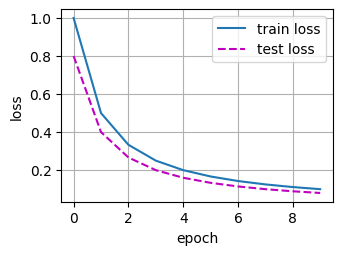

In [22]:
import matplotlib.pyplot as plt
from IPython import display

class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        
        # 设置 SVG 显示
        plt.rcParams['figure.figsize'] = figsize
        plt.rcParams['svg.fonttype'] = 'none'  # 使 SVG 中的文本可编辑
        
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes]
        else:
            self.axes = self.axes.flatten()
        
        # 配置坐标轴
        self.config_axes = lambda ax: self._set_axes(
            ax, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        
        self.X, self.Y, self.fmts = None, None, fmts
        self.legend = legend

    def _set_axes(self, ax, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
        """设置坐标轴属性"""
        if xlabel:
            ax.set_xlabel(xlabel)
        if ylabel:
            ax.set_ylabel(ylabel)
        if xlim:
            ax.set_xlim(xlim)
        if ylim:
            ax.set_ylim(ylim)
        if xscale:
            ax.set_xscale(xscale)
        if yscale:
            ax.set_yscale(yscale)
        if legend:
            ax.legend(legend)
        ax.grid(True)

    def add(self, x, y):
        """向图表中添加多个数据点"""
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        
        # 初始化数据存储
        if self.X is None:
            self.X = [[] for _ in range(n)]
        if self.Y is None:
            self.Y = [[] for _ in range(n)]
        
        # 添加数据点
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        
        # 清除并重新绘制
        self.axes[0].cla()
        for i, (x_data, y_data, fmt) in enumerate(zip(self.X, self.Y, self.fmts)):
            if x_data and y_data:  # 确保有数据可绘制
                self.axes[0].plot(x_data, y_data, fmt)
        
        # 配置坐标轴
        self.config_axes(self.axes[0])
        
        # 显示图形
        display.display(self.fig)
        display.clear_output(wait=True)

    def close(self):
        """关闭图形"""
        plt.close(self.fig)

# 使用示例
if __name__ == "__main__":
    # 在 Jupyter notebook 中测试
    animator = Animator(xlabel='epoch', ylabel='loss', legend=['train loss', 'test loss'])
    
    # 模拟添加数据
    for epoch in range(10):
        train_loss = 1.0 / (epoch + 1)
        test_loss = 0.8 / (epoch + 1)
        animator.add(epoch, [train_loss, test_loss])

### 训练函数

In [23]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    """训练模型"""
    # 定义一个动画显示
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
        
    train_loss, train_acc = train_metrics
    # 检测
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

### 优化器实现

In [24]:
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size # 求导数不影响乘除法，这里除是因为要用平均损失
            param.grad.zero_()

lr = 0.08

def updater(batch_size):
    return sgd([W, b], lr, batch_size)

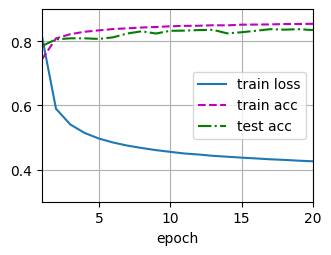

In [25]:
num_epochs = 20
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

### 进行实际预测

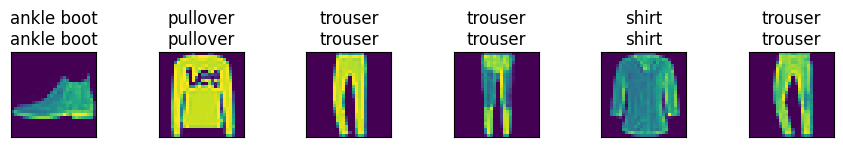

In [26]:
def predict_ch3(net, test_iter, n=6):
    """预测标签"""
    for X, y in test_iter:
        break
        
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]

    show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

# Softmax 简洁实现

In [27]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size=batch_size)

In [28]:
from torch import nn
# PyTorch不会隐式地调整输入的形状。因此，
# 我们在线性层前定义了展平层（flatten），来调整网络输入的形状
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        # 对 m层中所有的权重，执行均值0、标准差0.01的正态初始化
        # mean=0 默认，这里省略
        nn.init.normal_(m.weight, std=0.01) 

# 遍历所有层，对每个层都执行相同操作
net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

交叉熵损失函数，需要传入未归一化的预测（logits），同时计算softmax及其对数

In [29]:
loss = nn.CrossEntropyLoss()

优化算法，使用小批量随机梯度下降

In [30]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

开始训练

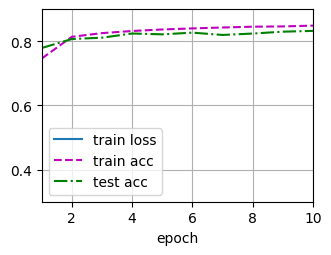

In [31]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)